In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
ya_path = 'development.csv'
ya_data_df = pd.read_csv(ya_path, names=['timestamp', 't', 'sum', 't_1', 'num_1', 't_2', 'num_500'])
ya_data_df = ya_data_df[['timestamp', 'num_1', 'num_500', 'sum']].copy()
ya_data_df.tail(5)

,timestamp,num_1,num_500,sum
52,2019-5-1,06/2019: #1 = 148.6 PFlop/s,06/2019: #500 = 1.0 PFlop/s],06/2019: Sum = 1.6 EFlop/s
53,2019-10-1,11/2019: #1 = 148.6 PFlop/s,11/2019: #500 = 1.1 PFlop/s],11/2019: Sum = 1.6 EFlop/s
54,2020-5-1,06/2020: #1 = 415.5 PFlop/s,06/2020: #500 = 1.2 PFlop/s],06/2020: Sum = 2.2 EFlop/s
55,2020-10-1,11/2020: #1 = 442.0 PFlop/s,11/2020: #500 = 1.3 PFlop/s],11/2020: Sum = 2.4 EFlop/s
56,2021-5-1,06/2021: #1 = 442.0 PFlop/s,06/2021: #500 = 1.5 PFlop/s],06/2021: Sum = 2.8 EFlop/s


# preprocess

In [3]:
def converter(postfix):
    if postfix == 'GFlop/s':
        return 10 ** 9
    elif postfix == 'TFlop/s':
        return 10 ** 12
    elif postfix == 'PFlop/s':
        return 10 ** 15
    return 10 ** 18

ya_data_df['num_1'] = ya_data_df['num_1'].str.split(' ').apply(lambda x: float(x[-2]) * converter(x[-1]))
ya_data_df['num_500'] = ya_data_df['num_500'].str.split(' ').apply(lambda x: float(x[-2]) * converter(x[-1][:-1]))
ya_data_df['sum'] = ya_data_df['sum'].str.split(' ').apply(lambda x: float(x[-2]) * converter(x[-1]))
ya_data_df['timestamp'] = pd.to_datetime(ya_data_df['timestamp'])
ya_data_df['timestamp']  = (ya_data_df['timestamp'] - pd.Timestamp("1993-05-01")).dt.days.values
ya_data_df.tail(5)

,timestamp,num_1,num_500,sum
52,9496,1.486000e+17,1.000000e+15,1.600000e+18
53,9649,1.486000e+17,1.100000e+15,1.600000e+18
54,9862,4.155000e+17,1.200000e+15,2.200000e+18
55,10015,4.420000e+17,1.300000e+15,2.400000e+18
56,10227,4.420000e+17,1.500000e+15,2.800000e+18


In [4]:
model = LinearRegression()

x_df = ya_data_df[['timestamp']].copy()
x_df['x_2'] = x_df['timestamp'] ** 2
y = (ya_data_df['num_1'].values).reshape(-1, 1)
model.fit(x_df, np.log(y))

LinearRegression()

In [5]:
x_df['num_1_pred'] = np.exp(model.predict(x_df))

<AxesSubplot:xlabel='timestamp'>

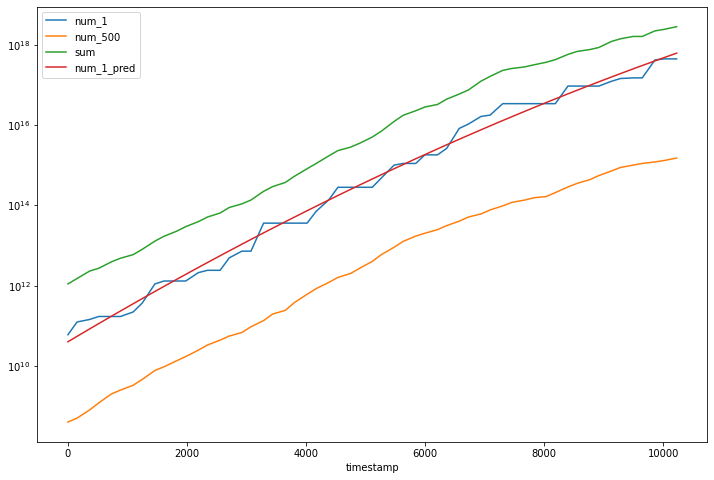

In [6]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
ya_data_df.plot('timestamp', ['num_1', 'num_500', 'sum'], ax=ax, logy=True)
x_df.plot('timestamp', ['num_1_pred'], ax=ax, logy=True)

In [7]:
pred_day = (pd.Timestamp("2021-01-01") - pd.Timestamp("1993-05-01")).days
pred_day_features = pd.DataFrame([[pred_day, pred_day** 2]])

In [8]:
ans = np.exp(model.predict(pred_day_features))
print(ans, ans // 10 ** 15, "PFlop/s")
#1 = 531.1 PFlop/s

[[5.31197838e+17]] [[531.]] PFlop/s


# Total supply

In [9]:
# https://en.wikipedia.org/wiki/List_of_countries_by_electricity_production
TOTAL_POWER_SUPPLY = 26823200 * 10 ** 9
path = 'TOP500_202106.csv'
data_df = pd.read_csv(path, sep=';')
data_df.head(2)

,Rank,Previous Rank,First Appearance,First Rank,Name,Computer,Site,Manufacturer,Country,Year,...,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Model,System Family,Interconnect Family,Interconnect,Continent,Site ID,System ID
0,1,1.0,55,1,Supercomputer Fugaku,"Supercomputer Fugaku, A64FX 48C 2.2GHz, Tofu i...",RIKEN Center for Computational Science,Fujitsu,Japan,2020,...,None,48,Fujitsu A64FX,Supercomputer Fugaku,Fujitsu Cluster,Proprietary Network,Tofu interconnect D,Asia,50 831,179807
1,2,2.0,51,1,Summit,"IBM Power System AC922, IBM POWER9 22C 3.07GHz...",DOE/SC/Oak Ridge National Laboratory,IBM,United States,2018,...,NVIDIA Volta GV100,22,IBM POWER9,IBM Power System AC922,IBM Power Systems,Infiniband,Dual-rail Mellanox EDR Infiniband,North America,48 553,179397


In [10]:
data_df['power'] = data_df['Power (kW)'].str.replace(u'\xa0', '').str.replace(',', '.').astype(float) * 1e3
median_power = data_df['power'].median()
data_df['power'] = data_df['power'].fillna(median_power)
total_super_power = data_df['power'].sum() * 24 * 365

In [11]:
total_super_power / TOTAL_POWER_SUPPLY * 100

0.02105986795311521